**NOTE: only test Data ist included with 10 rows**
**Forecasting der Residuallast im Stromnetz: Ein Machine-Learning Showcase von Simon&nbsp;Thiel zur Demonstration grundlegendener Methodenkompetenz**
- Setup für lauffähigen Docker-Container
- Import und Bereinigung von Daten für das Stromnetz vom 10.06.22 bis zum 10.06.2025
- Demonstration grundlegender SQL-Kompetenz
- Visualisierung der Residuallast als Plausibilitätsüberprüfung
- Import von Wetterdaten (requested von https://open-meteo.com/en/docs/historical-weather-api und als .csv gespeichert) für verschiedene Städte, resampling nach Tagesmittelwert (Sonnenstrahlung (W/m^2), Wind (km/h in 100m Höhe), Temperatur (°C)) Zusammenführen der Daten in ein großes DataFrame und Definition von Tag pro Jahr und Tag der Woche
- ML Workflow mit Gradient Boosting als Modell
- Relevanz der einzelnen Features

# Setup für reproduzierbare Ausführung im Docker-Container: 
- Notebook wurde nach Python-Skript (.py) konvertiert, 
- Abhängigkeiten über packages.txt definiert, 
- ein Dockerfile erstellt, um das Skript im Container lauffähig zu machen. 
(Daten liegen lokal vor und wurden im Showcase nicht mitgeliefert.)


Terminal-Befehl um Jupyter-Notebook-Datei in Python-Datei zu konvertieren.

Inhalt von Packages.txt

docker build -t stromnetz-analysis .
docker run --rm -v $(pwd):/Data_Analysis/Stromnetz stromnetz-analysis


Inhalt von Dockerfile

In [2]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Import und Bereinigung der Daten für das Stromnetz

In [3]:
data = pd.read_csv("consumption_3years.csv", sep=None, engine="python", encoding="utf-8-sig")

In [4]:
print(f"Spaltennamen und Typen:\n{data.dtypes}")

Spaltennamen und Typen:
Start date                                                         object
End date                                                           object
grid load [MWh] Original resolutions                               object
Grid load incl. hydro pumped storage [MWh] Original resolutions    object
Hydro pumped storage [MWh] Original resolutions                    object
Residual load [MWh] Original resolutions                           object
dtype: object


**Zeitspalte** in **Datetime** umwandeln.

In [5]:
data["Start date"]=pd.to_datetime(data["Start date"], format="%b %d, %Y %I:%M %p")
data["End date"]=pd.to_datetime(data["End date"], format="%b %d, %Y %I:%M %p")

**Spaltennamen** modifizieren und **Dezimalkommata entfernen**.

In [6]:
data.columns=data.columns.str.replace(" Original resolutions", "", regex=False)
for col in data.select_dtypes(include="object"):
    data[col] = (data[col].str.replace(",", "",regex=False))
    data[col] = pd.to_numeric(data[col])

**Überprüfung** ob **relevante Spalte** nur **Digits** enthält und ausgeben der **Datentypen** für alle **Spalten**.

In [7]:
non_numeric_mask = pd.to_numeric(data["Residual load [MWh]"], errors="coerce").isna()
if len(data[non_numeric_mask]) == 0:
    print("Keine Verunreinigung der betrachteten Spalte durch non-digits!")
else:
    print("Spalte enthält nicht ausschließlich digits!")

print(f"""\n\nNamen sind übersichtlicher und Daten sind jetzt numerisch:\n\n{data.dtypes}""")

Keine Verunreinigung der betrachteten Spalte durch non-digits!


Namen sind übersichtlicher und Daten sind jetzt numerisch:

Start date                                    datetime64[ns]
End date                                      datetime64[ns]
grid load [MWh]                                      float64
Grid load incl. hydro pumped storage [MWh]           float64
Hydro pumped storage [MWh]                           float64
Residual load [MWh]                                  float64
dtype: object


**Daten der Residuallast** werden aus dem DataFrame extrahiert und nach dem **Tag in Summe geresampled**.

In [8]:
print(f"Erste 4 Werte von Residual load [MWh] mit Datetimeangabe:\n\n{pd.concat([data.iloc[:5,0],data.iloc[:5,5]], axis=1)}")
data = data.set_index("Start date").sort_index()

# Nur Residual load pro Tag summieren
data_res = data[["Residual load [MWh]"]].resample("D").sum()
data_res = data_res.rename(columns={"Residual load [MWh]": "res"})
print(f"""\nNach Tagessumme geresamplete "Residual load [MWh]" (genannt res):\n{data_res.head()}""")

Erste 4 Werte von Residual load [MWh] mit Datetimeangabe:

           Start date  Residual load [MWh]
0 2022-06-10 00:00:00              9788.25
1 2022-06-10 00:15:00              9722.75
2 2022-06-10 00:30:00              9596.25
3 2022-06-10 00:45:00              9398.25
4 2022-06-10 01:00:00              9279.50

Nach Tagessumme geresamplete "Residual load [MWh]" (genannt res):
                  res
Start date           
2022-06-10  859971.00
2022-06-11  666921.75
2022-06-12  559318.25
2022-06-13  725882.25
2022-06-14  881550.25


# Visualisierung der Residuallast als Plausibilitätsüberprüfung

Residuallast ist wie erwartet im Winter am höchsten. (Höchster Heizbedarf, niedrigste Solarenergieerzeugung)

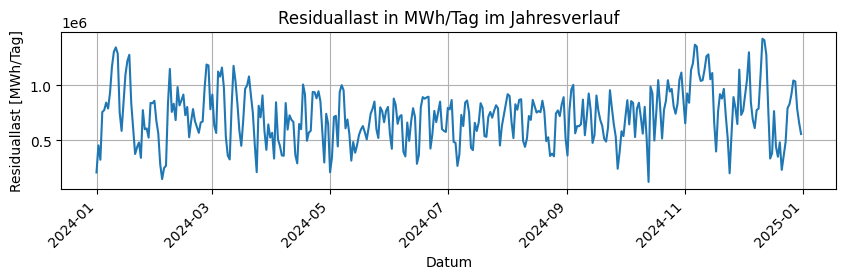

In [85]:
maske_1_year=(data_res.index.year == 2024)
data_1_year=data_res["res"].loc[maske_1_year]
y=data_1_year.values
x=data_1_year.index.date
plt.figure(figsize=(10, 2.5))
plt.subplots_adjust(bottom=0.25)
plt.plot(x,y)
plt.title("Residuallast in MWh/Tag im Jahresverlauf")
plt.xlabel("Datum")
plt.ylabel("Residuallast [MWh/Tag]")
plt.grid()
plt.xticks(rotation=45, ha="right")
plt.savefig("yearly_res.pdf")
plt.show()

# Import von Wetterdaten

Um die Daten für die **Residuallast** mit den **Wetterdaten** zusammenführen zu können, müssen die eingelesenen Daten ebenfalls nach dem **Tag geresampled** werden. Für Wetterdaten ist jedoch der Durchschnitt sinniger.

In [73]:
def read_resample(path, mode):
    temp = pd.read_csv(path, index_col="Zeit", parse_dates=["Zeit"])
    #data_dict[f"data_{name}"] = temp
    if mode == 0:
        temp=temp.resample("D").mean()
        temp_new=temp[["Temperatur (°C)", "Strahlung W/m^2"]]
        temp_new=temp_new.rename(columns={"Temperatur (°C)":"temp", "Strahlung W/m^2":"rad"})
        return temp_new
    elif mode == 1:
        temp=temp.resample("D").mean()
        temp_new=temp[["wind_100m", "Temperatur (°C)"]]
        temp_new=temp_new.rename(columns={"wind_100m": "wind", "Temperatur (°C)": "temp"})
        return temp_new
    else:
        print("""enter ("data_name.csv", number), 0 for temperature and radiation, or 1 for wind""")
        return None

Da es **regionale Unterschiede** gibt in der Erzeugung von Solar- und Windstrom, werden für die **nördlichen Städte (Kiel, Hannover, Roggenstede)** die Wetterdaten für den **Wind und Temperatur** berücksichtigt, für die **südlicheren Städte** die Daten für **Sonneneinstrahlung und Temperatur.**

In [74]:
data_berlin=read_resample("Berlin_Klima.csv",0)
data_muenchen=read_resample("München_Klima.csv",0)
data_karlsruhe=read_resample("Karlsruhe_Klima.csv",0)
data_kiel=read_resample("Kiel_Klima.csv",1)
data_duesseldorf=read_resample("Düsseldorf_Klima.csv",0)
data_hannover=read_resample("Hannover_Klima.csv",1)
data_roggenstede=read_resample("Roggenstede_Klima.csv",1)

#Datensatz für Roggenstede war größer, daher kurz mit Maske gewünschten Bereich auswählen
maske=(data_roggenstede.index.date >= pd.to_datetime("2022-06-10").date()) & (data_roggenstede.index.date <= pd.to_datetime("2025-06-10").date())
data_roggenstede=data_roggenstede.loc[maske]

In [75]:
print(f"So sehen die Daten jetzt aus:\nKiel\n{data_kiel.head()}\n\nMünchen\n{data_muenchen.head()}")

So sehen die Daten jetzt aus:
Kiel
                 wind       temp
Zeit                            
2022-06-10  21.641667  16.487500
2022-06-11  20.291667  17.075000
2022-06-12  24.291667  15.354167
2022-06-13  26.791667  13.562500
2022-06-14  23.000000  14.033333

München
                 temp         rad
Zeit                             
2022-06-10  15.020833  161.958333
2022-06-11  17.420833  199.875000
2022-06-12  20.479167  258.083333
2022-06-13  17.820833  201.083333
2022-06-14  16.945833  276.291667


Anschließend werden **Windgeschwindigkeit**, **Temperatur** und **Sonneneinstrahlung** über alle ausgewählten Städte gemittelt.

In [76]:
data_mean_rad=pd.DataFrame()
data_mean_temp=pd.DataFrame()
data_mean_wind=pd.DataFrame()
data_dict = {
    "data_muenchen": data_muenchen,
    "data_karlsruhe": data_karlsruhe,
    "data_duesseldorf": data_duesseldorf,
    "data_berlin": data_berlin,
    "data_kiel": data_kiel,
    "data_hannover": data_hannover,
    "data_roggenstede": data_roggenstede,
}

rad_name_list  = ["data_muenchen", "data_karlsruhe", "data_duesseldorf", "data_berlin"]
wind_name_list = ["data_kiel", "data_hannover", "data_roggenstede"]
temp_name_list = rad_name_list + wind_name_list

list_rad=[]
list_wind=[]
list_temp=[]

for name in rad_name_list:
    list_rad.append(data_dict[name]["rad"])
for name in wind_name_list:
    list_wind.append(data_dict[name]["wind"])
for name in temp_name_list:
    list_temp.append(data_dict[name]["temp"])

data_rad_all=pd.concat(list_rad, axis=1)  
data_rad_all_mean=data_rad_all.mean(axis=1) 
data_mean_rad["rad"]=data_rad_all_mean

data_temp_all=pd.concat(list_temp, axis=1)  
data_temp_all_mean=data_temp_all.mean(axis=1) 
data_mean_temp["temp"]=data_temp_all_mean

data_wind_all=pd.concat(list_wind, axis=1)
data_wind_all_mean=data_wind_all.mean(axis=1)
data_mean_wind["wind"]=data_wind_all_mean

# Zusammenführen der Daten und Vorbereitung von Features und Target

In [77]:
climate_data_list = [data_mean_rad, data_mean_temp, data_mean_wind]
climate_data = pd.concat(climate_data_list, axis=1)
print(f"DataFrame für die berücksichtigten Wetterdaten:\n\n{climate_data.head()}")

DataFrame für die berücksichtigten Wetterdaten:

                   rad       temp       wind
Zeit                                        
2022-06-10  179.520833  16.930357  20.509722
2022-06-11  160.885417  18.922619  22.058333
2022-06-12  223.677083  18.470238  22.172222
2022-06-13  163.895833  15.911905  25.806944
2022-06-14  219.958333  15.698810  16.340278


**Wetterdaten und Residuallast** werden in einem DataFrame ml_data zusammengeführt.

Für das Modell werden alle numerischen Variablen als Eingangsgrößen berücksichtigt (**rad**, **temp**, **wind**, **dayofweek**, **dayofyear**). Die Zielvariable **res** in MWh/Tag (Residuallast) wird ausgeschlossen.

- **rad** (Sonneneinstrahlung in W/m²) und **wind** (Windgeschwindigkeit in km/h in 100m Höhe) repräsentieren die wetterabhängige Einspeisung aus Photovoltaik- und Windkraftanlagen.

- Die Temperatur in (°C) **temp** wird mit einbezogen, um z.B. die Heizlast zu berücksichtigen 

- **dayofweek** bildet Unterschiede im Verbrauchsverhalten zwischen Werktagen (Mo–Fr, höherer Industrie- und Gewerbelast) und Wochenenden ab.

- **dayofyear** erfasst saisonale Effekte, etwa höhere PV-Erzeugung im Sommer und geringere im Winter.

Damit kombiniert das Modell sowohl wetterbedingte Einflussfaktoren als auch typische zeitliche Muster des Stromverbrauchs.

In [78]:
ml_data=climate_data.join(data_res, how="outer")
ml_data = ml_data.reset_index().rename(columns={"Zeit": "date"})
ml_data["dayofweek"] = ml_data["date"].dt.dayofweek     # 0=Mo..6=So
ml_data["dayofyear"] = ml_data["date"].dt.dayofyear 
target = "res"
num_cols = ml_data.select_dtypes(include=[np.number]).columns.tolist()

feature_cols=[]
for c in num_cols:
    if c != target:
        feature_cols.append(c)
print(f"Auflistung aller Features:\n{feature_cols}\n")
print(f"Datentypen stimmen alle:\n\n{ml_data.dtypes}") 

Auflistung aller Features:
['rad', 'temp', 'wind', 'dayofweek', 'dayofyear']

Datentypen stimmen alle:

date         datetime64[ns]
rad                 float64
temp                float64
wind                float64
res                 float64
dayofweek             int32
dayofyear             int32
dtype: object


# ML-Workflow

**Definition** von features **X** und target **y**

In [79]:
X = ml_data[feature_cols]
y = ml_data[target]
nan_test=y.isna().any()
if nan_test:
    print("ACHTUNG! NaN in Target")
else:
    print("Keine NaN in Target!")
print(f"\nAlle features:\n\n{X.head()}\n")
print(f"""Target "res"\n\n{y.head()}""")

Keine NaN in Target!

Alle features:

          rad       temp       wind  dayofweek  dayofyear
0  179.520833  16.930357  20.509722          4        161
1  160.885417  18.922619  22.058333          5        162
2  223.677083  18.470238  22.172222          6        163
3  163.895833  15.911905  25.806944          0        164
4  219.958333  15.698810  16.340278          1        165

Target "res"

0    859971.00
1    666921.75
2    559318.25
3    725882.25
4    881550.25
Name: res, dtype: float64


**Aufteilung** in Test und Trainingsdatensatz, **80% Trainingsdaten** (**chronologisch** erste 80% da **shuffle=False**), 20% Testdaten  (chronologisch letzte 20%).

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Der Modellierungs-Workflow bestand aus folgenden Schritten:

1. **Preprocessing**: fehlende Werte wurden mit dem Median ersetzt (SimpleImputer).  
2. **Modelltraining**: ein GradientBoostingRegressor wurde mit 500 Bäumen, einer maximalen Tiefe von 3 und einer Lernrate von 0.05 trainiert.  
3. **Vorhersage**: die Residuallast im Testzeitraum wurde prognostiziert.  
4. **Bewertung**: die Modellgüte wurde anhand der Kennzahlen MAE und MAPE bewertet.  

In [81]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GradientBoostingRegressor(
        n_estimators=500,     
        learning_rate=0.05,   
        max_depth=3,          
        random_state=42
    ))
])

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mape = (np.abs((y_test - pred) / y_test.replace(0, np.nan))).mean() * 100
print(f"GradientBoosting: MAE={mae:.0f} MWh/Tag  |  MAPE={mape:.2f}%")
print("MAE = Mittlerer absoluter Fehler;  MAPE = Mittlerer absoluter prozentualer Fehler")
print(f"\nMAE={mae:.0f} MWh/Tag bedeutet: Das Modell liegt im Mittel um {mae:.0f} MWh/Tag daneben.")
print(f"MAPE={mape:.2f}% bedeutet: Im Mittel liegt die Prognose um {mape:.2f}% daneben.")
print("\nHinweis: Die Fehler beziehen sich auf perfekte Wetter-Historie.")
print("In der Praxis kommt zusätzlich der Fehler der Wettervorhersage hinzu.")

GradientBoosting: MAE=84158 MWh/Tag  |  MAPE=14.13%
MAE = Mittlerer absoluter Fehler;  MAPE = Mittlerer absoluter prozentualer Fehler

MAE=84158 MWh/Tag bedeutet: Das Modell liegt im Mittel um 84158 MWh/Tag daneben.
MAPE=14.13% bedeutet: Im Mittel liegt die Prognose um 14.13% daneben.

Hinweis: Die Fehler beziehen sich auf perfekte Wetter-Historie.
In der Praxis kommt zusätzlich der Fehler der Wettervorhersage hinzu.


Zur Überprüfung, ob das GradientBoosting-Modell tatsächlich einen Mehrwert bietet, wird es mit einer simplen Referenzmethode verglichen: der **Gestern=Heute-Vorhersage**.
Dabei wird die Residuallast von Tag t als Vorhersage für Tag t+1 verwendet. Technisch wird hierfür eine Prognose-Serie **y_simple** erzeugt, die um **einen Tag nach vorne verschoben** ist.
Anschließend werden die Werte im Testzeitraum mit den tatsächlichen Residuallasten verglichen und die Fehlermaße **MAE** und **MAPE** berechnet.
So lässt sich direkt quantifizieren, in welchem Umfang das **GradientBoosting-Modell die simple Vorhersage übertrifft**.

In [82]:
steps = 1
y_simple = y.shift(steps)

simple_pred = y_simple.loc[y_test.index]
simple_truth = y_test


mae_simple = mean_absolute_error(simple_truth, simple_pred)

mask = simple_truth != 0
mape_simple = (np.abs((simple_truth[mask] - simple_pred[mask]) / simple_truth[mask])).mean() * 100

print(f"Gestern-Heute-Vorhersage: MAE={mae_simple:.0f} MWh/Tag  MAPE={mape_simple:.2f}%")
print(f"GradientBoosting: MAE={mae:.0f} MWh/Tag  MAPE={mape:.2f}%")
mae_reduce=(mae_simple-mae)/mae_simple*100
mape_reduce=(mape_simple-mape)/mape_simple*100
print(f"\nDas GradientBoosting-Modell reduziert den MAE um {mae_reduce:.1f}% \nund den MAPE um {mape_reduce:.1f}% im Vergleich zur Gestern-Heute-Vorhersage.")

Gestern-Heute-Vorhersage: MAE=174076 MWh/Tag  MAPE=29.40%
GradientBoosting: MAE=84158 MWh/Tag  MAPE=14.13%

Das GradientBoosting-Modell reduziert den MAE um 51.7% 
und den MAPE um 51.9% im Vergleich zur Gestern-Heute-Vorhersage.


# Relevanz der einzelnen Features

Anschließend wird die Wichtigkeit der einzelnen Features **fi** aus dem **trainierten GradientBoosting-Modell** extrahiert, den zugehörigen Spaltennamen zugeordnet und der Größe nach sortiert.  

Die Werte geben an, wie stark jedes Feature relativ im Modell genutzt wurde, also wie stark es in den Entscheidungsbäumen des Modells zur Verbesserung der Vorhersage herangezogen wurde. 

Die einzelnen Werte dienen als **Indikator**, welche der genutzten Features für die Prognose der Residuallast im Modell am wichtigsten sind.


In [83]:
gb_model = pipe.named_steps["model"]
fi = pd.Series(gb_model.feature_importances_, index=X_train.columns)

fi = fi.sort_values(ascending=False)
print(f"Gewichtung der einzelnen Features:\n{fi}")  

sum_fi = fi.sum()
print(f"Summe der Gewichte: {sum_fi}")
print("\nDie Werte geben also die relative Wichtigkeit der Features im Modell an.")

Gewichtung der einzelnen Features:
wind         0.442119
temp         0.180607
dayofweek    0.174729
rad          0.133410
dayofyear    0.069135
dtype: float64
Summe der Gewichte: 1.0

Die Werte geben also die relative Wichtigkeit der Features im Modell an.


**Grafische Darstellung** der Wichtigkeit der einzelnen Features.

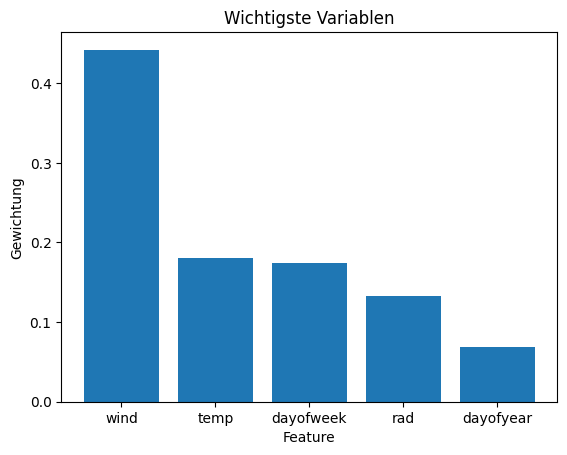

In [86]:
y=fi.values
x=fi.index
plt.figure()
plt.bar(x,y)
plt.xlabel("Feature")
plt.ylabel("Gewichtung")
plt.title("Wichtigste Variablen")
plt.savefig("wichtigste_var.pdf")
plt.show()